In [1]:
import torch
from torch import nn
from d2l import torch as d2l

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size = 256)

In [18]:
def batch_norm(X, gemma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat =  (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim = 0)
            var = ((X - mean) ** 2).mean(dim = 0)
        else:
            mean = X.mean(dim = (0, 2 ,3), keepdim = True)
            var = ((X - mean) ** 2).mean(dim = (0, 2 ,3), keepdim = True)

        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var

    Y = gemma * X_hat + beta    
    
    return Y, moving_mean.data, moving_var.data  # tensor的data属性返回的还是tensor，但是parameters()的data属性返回的时tensor

In [3]:
X = torch.rand((8, 8))
gemma, beta = torch.ones((8, 1)), torch.zeros((8, 1))
moving_mean, moving_var = torch.zeros((8, 1)), torch.ones((8, 1)),
eps, momentum = 1e-5, 0.9
Y, moving_mean, moving_var = batch_norm(X, gemma, beta, moving_mean, moving_var, eps, momentum)

In [19]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        assert num_dims in (2, 4)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gemma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gemma, self.beta, 
                                                          self.moving_mean, self.moving_var, 1e-5, 0.9)
        return Y


In [20]:
class LeNetBN(nn.Module):
    def __init__(self, usr_pytorch = False):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
                                  kernel_size=5, padding = 2)
        self.bn1 = nn.BatchNorm2d(6) if usr_pytorch else BatchNorm(6, 4)
        self.ac_1 = nn.Sigmoid()
        self.pooling_1 = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.conv2d_2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16) if usr_pytorch else BatchNorm(16, 4)
        self.ac_2 = nn.Sigmoid()
        self.pooling_2 = nn.AvgPool2d(kernel_size = 2, stride = 2)

        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120) if usr_pytorch else BatchNorm(120, 2) 
        self.ac_3 = nn.Sigmoid()
        self.linear_2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84) if usr_pytorch else BatchNorm(84, 2) 
        self.ac_4 = nn.Sigmoid()
        self.linear_3 = nn.Linear(84, 10)

    def forward(self, X):
        output_conv_1 = self.pooling_1(self.ac_1(self.bn1(self.conv2d_1(X))))
        output_conv_2 = self.pooling_2(self.ac_2(self.bn2(self.conv2d_2(output_conv_1))))

        output = self.flatten(output_conv_2)
        output = self.ac_3(self.bn3(self.linear_1(output)))
        output = self.ac_4(self.bn4(self.linear_2(output)))

        return self.linear_3(output)

net = LeNetBN(False)

loss 0.253, train acc 0.906, test acc 0.825
70495.8 examples/sec on cuda


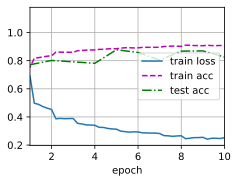

In [21]:
d2l.train_ch6(net, train_iter, test_iter, 10, 1, "cuda")

In [10]:
net = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=5, padding = 2), nn.BatchNorm2d(6), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2),
                    nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
                    nn.Linear(84, 10)
                    )

loss 0.252, train acc 0.906, test acc 0.863
98158.6 examples/sec on cuda


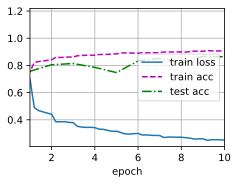

In [11]:
d2l.train_ch6(net, train_iter, test_iter, 10, 1, "cuda")